# Observational Studies

To draw causal conclusions on the impact of our features on movie success, we have to perform the standard operations used in observational studies, such as propensity matching and regression.

## Packages

In [18]:
# Global packages
import pandas as pd
import numpy as np
# Statistical package
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import statistics
# Matching package
from psmpy import PsmPy
from psmpy.functions import cohenD
from psmpy.plotting import *
# Custom helpers
import feature_and_regression as feat_and_reg
%load_ext autoreload
%autoreload 2
import warnings
warnings.simplefilter(action='ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [19]:
# First gather the initial regression dataframe.

raw_regression_df = feat_and_reg.get_raw_regression_df({})

In [20]:
# Format the regression dataframe
processed_df, target, binary_target, num_votes = feat_and_reg.format_regression_df(
                                                            raw_regression_df,[],bad_movies=True)
processed_df

,Western Europe,Asia,Africa and Middle-East,Eastern Europe and Russia,Central and South America,actor_number,gender_ratio,has_famous_actor,action,adventure,...,horror,animation,children,adult,fantasy,genre,title_length,combinned_movie_num,num_directors,combinned_movie_success
movie_id,,,,,,,,,,,,,,,,,,,,,
975900,0.0,0.0,0.0,0.0,0.0,17.0,-0.294118,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.165379,14.0,1.0,1
28463795,1.0,0.0,0.0,0.0,0.0,4.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.539345,1.0,1.0,0
261236,1.0,0.0,0.0,0.0,0.0,3.0,-0.333333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.870103,1.0,1.0,0
10408933,0.0,0.0,0.0,0.0,0.0,4.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.165379,18.0,1.0,1
24229100,0.0,1.0,0.0,0.0,0.0,5.0,-0.200000,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.984274,2.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28373912,0.0,0.0,0.0,1.0,0.0,20.0,-0.700000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.539345,4.0,1.0,1
1918494,1.0,0.0,0.0,0.0,0.0,24.0,-0.636364,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.165379,6.0,1.0,1
664006,0.0,0.0,0.0,0.0,0.0,8.0,-0.250000,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.165379,33.0,1.0,1


In [21]:
#Load the budget data and prepare it to merge it with processed_df
budget_df = pd.read_csv("../../data/imdb/imdb-movies.csv")
budget_df = budget_df[['imdb_id', 'budget']]
budget_df = budget_df[budget_df.budget != 0]
mapping = pd.read_pickle("../../data/generated/wikipedia_imdb_mapping_df.pkl")
mapping = mapping.reset_index()
mapping.rename(columns = {'tconst':'imdb_id'}, inplace = True)
budget_df = mapping.merge(budget_df)
budget_df = budget_df.drop('imdb_id', axis = 1)

In [22]:
processed_df = processed_df.merge(budget_df, right_on = 'movie_id', left_index=True, how='left')
processed_df = processed_df.set_index('movie_id')
processed_df = processed_df.dropna()


array([[<AxesSubplot:title={'center':'budget'}>]], dtype=object)

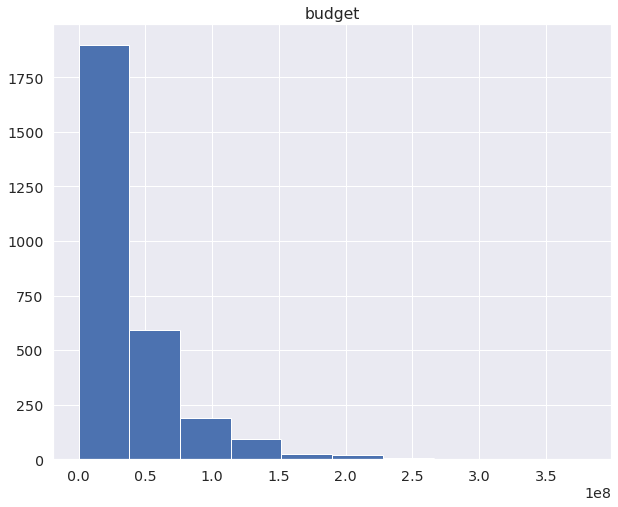

In [23]:
# Need to normalise the budget data, so we plot it to see it is a power law so we need to log it
processed_df.hist(column='budget')

In [24]:
processed_df['budget'] = np.log(processed_df['budget'])

In [25]:
# Normalise the data using min-max method
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(processed_df[['budget']])
processed_df['budget'] = normalized_data

In [26]:
# Method to binarize the data
def binarize_treatment(processed_dataframe: pd.DataFrame,
                       treatment: str, threshold: float, method="greater"):
    """
    
    :param processed_dataframe: Pandas DataFrame containing the data for regression.
    :param treatment: Covariate used as treament (should be binary).
    :param threshold: Threshold value for the binarization.
    :param method: Method for binarization with respect to the threshold.
    """
    if method == "greater":
        f = lambda l: l > threshold
    elif method == "smaller":
        f = lambda l: l < threshold
    elif method == "equal":
        f = lambda l: l == threshold
    elif method == "unequal":
        f = lambda l: l != threshold
    else:
        ValueError("Please provide a method in [greater,smaller,equal,unequal].")
    processed_dataframe[treatment] = processed_dataframe[treatment].apply(f)
    processed_dataframe[treatment] = processed_dataframe[treatment].replace({True: 1, False: 0})

In [27]:
# Binarize the budget using the median
median = statistics.median(processed_df['budget'].values)
binarize_treatment(processed_df, 'budget', median, method="smaller")

In [28]:
# Get the binary targets of the remaining movies in processed_df
binary_merge = pd.merge(processed_df, binary_target, left_index=True, right_index=True)
binary_target = binary_merge['average_rating']

## Propensity Score

### Budget

In [29]:
# Compute propensity scores
psm = PsmPy(processed_df.reset_index(), treatment='action', indx='movie_id', exclude = [])
psm.logistic_ps(balance = True)

In [30]:
# Creates matching and print summary of logisitic regression
psm.knn_matched(matcher='propensity_logit', replacement=False, caliper=None)
matched_ids = set(psm.matched_ids["movie_id"]).union(psm.matched_ids["matched_ID"])
matched_df = processed_df[processed_df.index.isin(matched_ids)]
matched_targets = binary_target[processed_df.index.isin(matched_ids)]
features_matched = feat_and_reg.forward_selection(matched_df, matched_targets, log_reg=True)
if 'action' not in features_matched:
    features_matched.append('action')
model_matched = sm.Logit(matched_targets, sm.add_constant(matched_df[features_matched])).fit(disp = False)
print(model_matched.summary())

Optimization terminated successfully.
         Current function value: 0.688212
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691170
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691055
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.691148
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.691075
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681064
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.681945
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687000
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688992
  

Optimization terminated successfully.
         Current function value: 0.620722
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624625
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624923
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624505
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624754
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.625083
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624057
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616814
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617385
  

Optimization terminated successfully.
         Current function value: 0.594996
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.594843
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595027
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595188
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.595207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.592579
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.593263
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.593287
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.593218
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.593296
  